# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation
- Name: Madalina Tilvan
- ID: 9058215

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from sklearn import datasets, tree, neighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

## Part 1
### Getting the Data 

In [45]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True, as_frame=True)

# merge the target variable with the X data for analysis
merged_df = pd.merge(diabetes_X, diabetes_y, left_index=True, right_index=True) 
merged_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.0381,0.0507,0.0617,0.0219,-0.0442,-0.0348,-0.0434,-0.0026,0.0199,-0.0176,151.0000
1,-0.0019,-0.0446,-0.0515,-0.0263,-0.0084,-0.0192,0.0744,-0.0395,-0.0683,-0.0922,75.0000
2,0.0853,0.0507,0.0445,-0.0057,-0.0456,-0.0342,-0.0324,-0.0026,0.0029,-0.0259,141.0000
3,-0.0891,-0.0446,-0.0116,-0.0367,0.0122,0.0250,-0.0360,0.0343,0.0227,-0.0094,206.0000
4,0.0054,-0.0446,-0.0364,0.0219,0.0039,0.0156,0.0081,-0.0026,-0.0320,-0.0466,135.0000
...,...,...,...,...,...,...,...,...,...,...,...
437,0.0417,0.0507,0.0197,0.0597,-0.0057,-0.0026,-0.0287,-0.0026,0.0312,0.0072,178.0000
438,-0.0055,0.0507,-0.0159,-0.0676,0.0493,0.0792,-0.0287,0.0343,-0.0181,0.0445,104.0000
439,0.0417,0.0507,-0.0159,0.0173,-0.0373,-0.0138,-0.0250,-0.0111,-0.0469,0.0155,132.0000
440,-0.0455,-0.0446,0.0391,0.0012,0.0163,0.0153,-0.0287,0.0266,0.0445,-0.0259,220.0000


### Framing the Problem

My goal is to choose and build a model that can accurately predict the risk of diabetes progression (target). This model will be used as a screening tool to help physicians with identifying patients at risk. 

To adress this problem, I will explore the following models:
1. Univariate Polynomial Regression: relationship between bmi and diabetes progression
2. Multivariate Polynomial Regression: non-linear relationship between multiple features (body mass index, blood pressure, total cholesterol, log of serum triglycerides level, blood sugar level) and the diabetes progression
3. Decision Trees: identifying patters and relationships between multiple features to predict diabetes progression
4. K-Nearest Neighbors (KNNs): comparing new cases with existing data

#### Diabetes dataset
The dataset contains the following independent variables:
- age, in years
- sex
- bmi, body mass index
- bp, average blood pressure, 
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

**Dataset Characteristics:**

**Number of Instances:** 442

**Number of Attributes:** 10 columns with numeric values

**Target:** Quantitative measure of disease progression one year after baseline

### Exploratory Data Analysis (EDA)

In [46]:
## explore statistics
merged_df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000,442.0000
mean,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,152.1335
std,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,0.0476,77.0930
min,-0.1072,-0.0446,-0.0903,-0.1124,-0.1268,-0.1156,-0.1023,-0.0764,-0.1261,-0.1378,25.0000
25%,-0.0373,-0.0446,-0.0342,-0.0367,-0.0342,-0.0304,-0.0351,-0.0395,-0.0332,-0.0332,87.0000
50%,0.0054,-0.0446,-0.0073,-0.0057,-0.0043,-0.0038,-0.0066,-0.0026,-0.0019,-0.0011,140.5000
75%,0.0381,0.0507,0.0312,0.0356,0.0284,0.0298,0.0293,0.0343,0.0324,0.0279,211.5000
max,0.1107,0.0507,0.1706,0.1320,0.1539,0.1988,0.1812,0.1852,0.1336,0.1356,346.0000


**Descriptive statistics**

The data appears to be standardised, with all features scaled between 0 and 1. This helps simplify the analysis by making sure that features with different units would not negatively affect the models. The target variable is the only one not transformed, but this will not affect the model's performance.

<Figure size 1000x800 with 0 Axes>

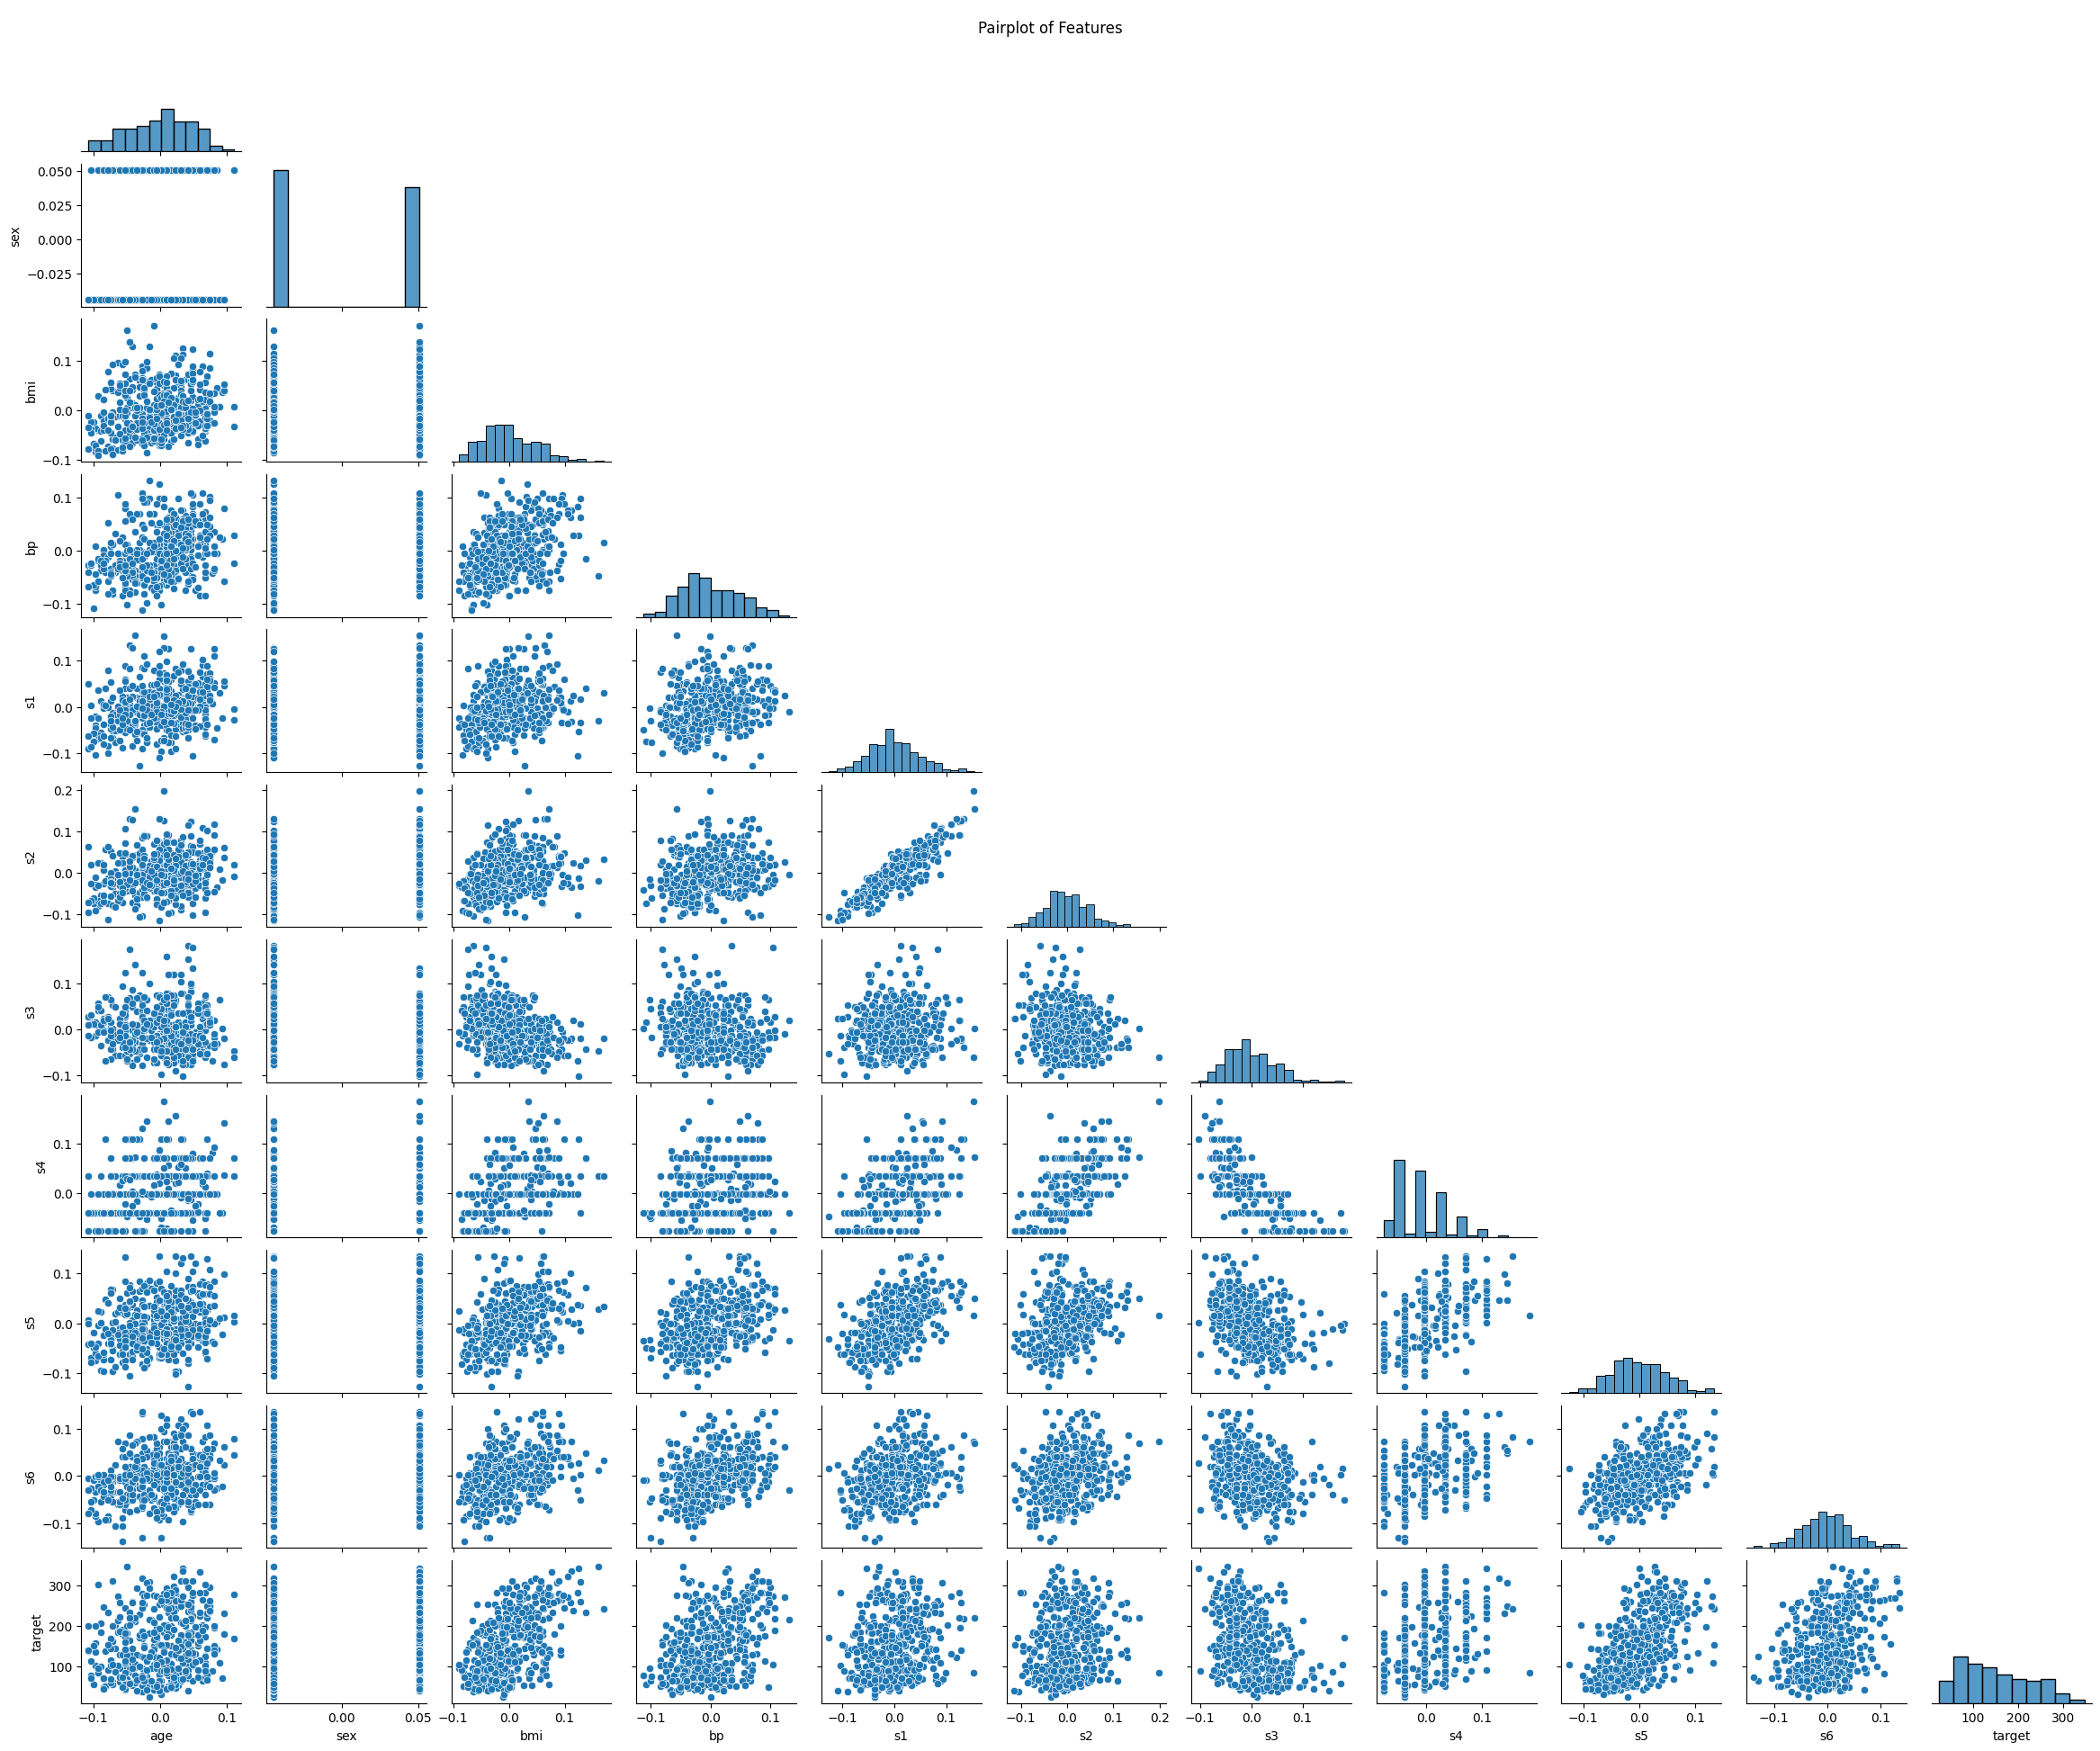

In [47]:
## Scatter pairplots
plt.figure(figsize=(10,8))
sns.pairplot(merged_df, height=1.8, aspect=1.2, corner=True)
plt.suptitle('Pairplot of Features')
plt.show()

**Scatter Pairplot**

The scatter pairplot shows several positive correlations between the features. However, most data points are very scattered, which indicates weak relationships. The strongest correlation is observed between s1 (total serum cholesterol) and s2 (low-density lipoproteins), suggesting potential multicollinearity. 

Only a few variables tend to have negative correlations, mainly between s3 (high-density lipoproteins) and the body mass index, or with s4 (total cholesterol / HDL).

The sex variable shows no clear pattern, likely because it is a categorical variable. 

Most variables show a normal distribution based on the histograms, with a few displaying right-skewed distributions. 

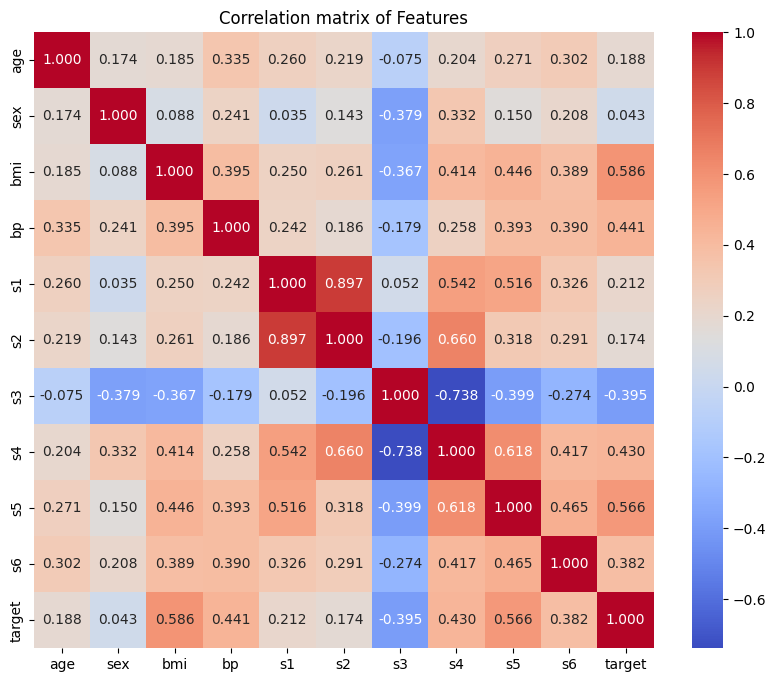

In [48]:
## Correlation matrix
corr_X = merged_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_X, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation matrix of Features')
plt.show()

#### Insights

**Correlation matrix**

The focus of the analysis is on the last line, which shows the correlation values between the target variable at the features. Features that show the strongest positive or negative correlations are most likely to have a bigger impact on the prediction of diabetes progression. 

For example, the bmi feature has the highest positive correlation with the target (0.586), which makes it the perfect choice for the univariate polynomial analysis. We can also observe a negative correlation with the s3 feature (-0.395). 

Looking at the matrix overall, we can observe strong correlations between s1 and s2 (0.897) and between s3 and s4 (0.738). These relationships may lead to multicollinearity issues that could reduce the performance of our models, and should be avoided if possible.


### Preprocessing

In [49]:
## check for missing values
print(f"Missing values \nX: \n{diabetes_X.isna().sum()}\ny: {diabetes_y.isna().sum()}")

## check data types
print(f"Data types \nX: \n{diabetes_X.dtypes} \ny: {diabetes_y.dtypes}")

Missing values 
X: 
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64
y: 0
Data types 
X: 
age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
dtype: object 
y: float64


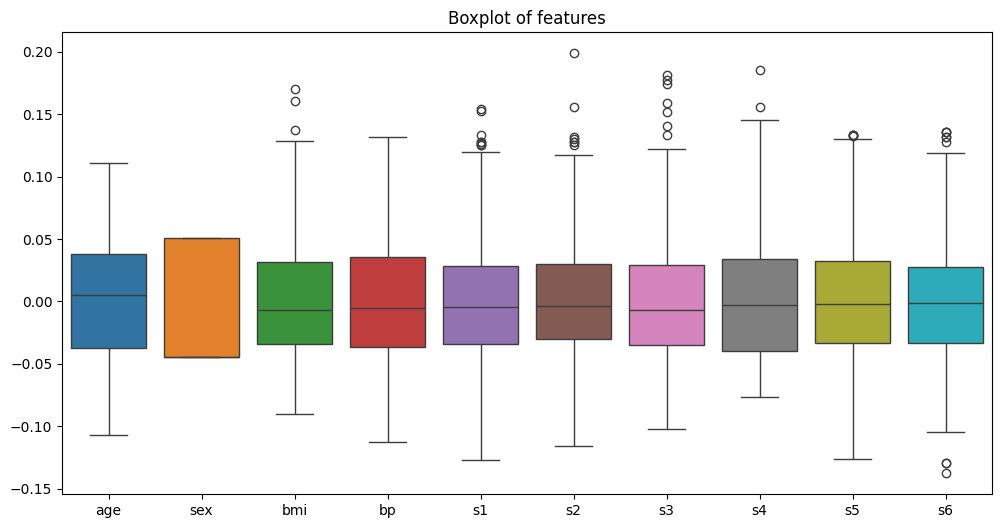

In [50]:
## check for outliers between features
plt.figure(figsize=(12, 6))
sns.boxplot(data=diabetes_X)
plt.title('Boxplot of features')
plt.show()

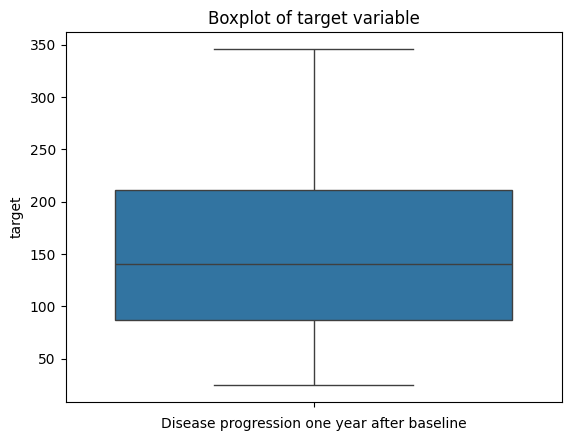

In [51]:
## check for outliers for target
sns.boxplot(data=diabetes_y)
plt.title('Boxplot of target variable')
plt.xlabel("Disease progression one year after baseline")
plt.show()

The diabetes dataset is already cleaned and preprocessed, each feature has been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1).

From my checks, we can confirm that there are no missing values and the datatypes are all float values. However, the boxplot shows a few outliers that are not too extreme, only 0.1 outside the regular range. These mild outliers make sense in the context of diabetes (bmi, total cholesterol or blood sugar levels) and they should not be removed.

## Part 2
### Fitting models
### 1. Univariate Polynomial Regression model

*Split the dataset to a train (75%) and validation set (10%), and test set (15%).*

In [52]:
## to create the split I use train_test_split twice, first to split the train and test sets, then to split again into validation and test
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
        diabetes_X['bmi'], diabetes_y, test_size=1-train_ratio, random_state=0)
X_val_diabetes, X_test_diabetes, y_val_diabetes, y_test_diabetes = train_test_split(
        X_test_diabetes, y_test_diabetes, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)

We'll create 6 models, from degree 0 to 5 with:

**X -** *bmi* <br>
**y -** *disease progression one year after baseline*

In [53]:
## making use of helper function for fitting multiple polynomial models at once
def polynomial_models(X, y, degrees: List[int]):
    models = {}
    for degree in degrees:
        model = Pipeline([('polynomial', PolynomialFeatures(degree=degree)),
                          ('linear', LinearRegression())])
        model.fit(X, y)
        models[degree] = model
    return models

In [54]:
degrees = list(range(0, 6)) ## list of degrees
models = polynomial_models(X_train_diabetes.values.reshape(-1,1), y_train_diabetes, degrees)

*Compare the models using the training and validation data and summarize the train validation results.*
1. *R-Squared - `r2_score`*
2. *Mean Absolute Error (MAE) - `mean_absolute_error`*
3. *MAPE - `mean_absolute_percentage_error`*

In [55]:
## helper function
def calculate_results(y_true, y_pred):
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    return R2, MAE, MAPE

models_results = []
## calculate results from train and validation sets 
for degree, model in models.items():
    y_pred_train = model.predict(X_train_diabetes.values.reshape(-1,1))
    y_pred_val = model.predict(X_val_diabetes.values.reshape(-1,1))
    R2_train, MAE_train, MAPE_train = calculate_results(y_train_diabetes, y_pred_train)
    R2_val, MAE_val, MAPE_val = calculate_results(y_val_diabetes, y_pred_val)
    models_results.append((degree, R2_train, R2_val, MAE_train, MAE_val, MAPE_train, MAPE_val))

results_df = pd.DataFrame(models_results, columns=[
        'Model degree', 'Train R-Squared', 'Validation R-Squared', 'Train MAE', 'Validation MAE', 'Train MAPE', 'Validation MAPE'])

## make sure the columns are displayed fully (only needs to be run once)
pd.set_option("display.float_format", "{:.4f}".format)

results_df

,Model degree,Train R-Squared,Validation R-Squared,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,0,0.0000,-0.1466,68.2320,58.5406,0.6517,0.3764
1,1,0.3910,0.1065,50.9784,54.1659,0.4781,0.3504
2,2,0.3910,0.1051,50.9723,54.2051,0.4780,0.3504
3,3,0.3939,0.1021,50.6033,54.1775,0.4739,0.3496
4,4,0.3946,0.1110,50.5306,53.8968,0.4723,0.3495
5,5,0.3966,0.1102,50.4814,53.9878,0.4719,0.3501


The results show that there might be a potential risk of overfitting, due to the Validation R-squared being lower than Train R-squared. While, models seem to improve with the increasing degree, the improvement stops at degree 4. Degree 5 doesn't seem to provide any significant increase in the validation results, making degree 4 the best choice for our analysis.

**Best Model: Model with degree 4**
- Highest Validation R-squared (0.1110)
- Lowest Validation MAE (53.8968)
- Lowest Validation MAPE (0.3495)

*Run the model on the test set and provide results.*

In [56]:
models[4].fit(X_train_diabetes.values.reshape(-1,1), y_train_diabetes)
y_pred_test = models[4].predict(X_test_diabetes.values.reshape(-1,1))
R2_test, MAE_test, MAPE_test = calculate_results(y_test_diabetes, y_pred_test)

print(f"Model degree 4 test metrics:\n R-Squared: {R2_test}\n MAE: {MAE_test}\n MAPE: {MAPE_test}")

Model degree 4 test metrics:
 R-Squared: 0.028940877683267807
 MAE: 53.03323274085463
 MAPE: 0.5452768985469199


*Plot a graph of the train, validation and test data points, and the fit of the chosen model over each of them.*

In [57]:
def plot_models(data_list, model, color_list, types_list):
    plt.figure(figsize=(12,8))

    i = 0 ## used for traversing the color and types lists
    for X, y in data_list:
        ## generate a continous array of 100 evenly spaced points based on X data
        X_continuous = np.linspace(min(X), max(X), 100) 
        
        plt.scatter(X, y, edgecolor="grey", c=color_list[i], label=types_list[i] + " data")
        plt.plot(X_continuous, model.predict(X_continuous), color=color_list[i], label=types_list[i] + " fit", linewidth=3)
        i = i + 1
    plt.xlabel("BMI (X)")
    plt.ylabel("Disease progression (y)")
    plt.legend()
    plt.show()

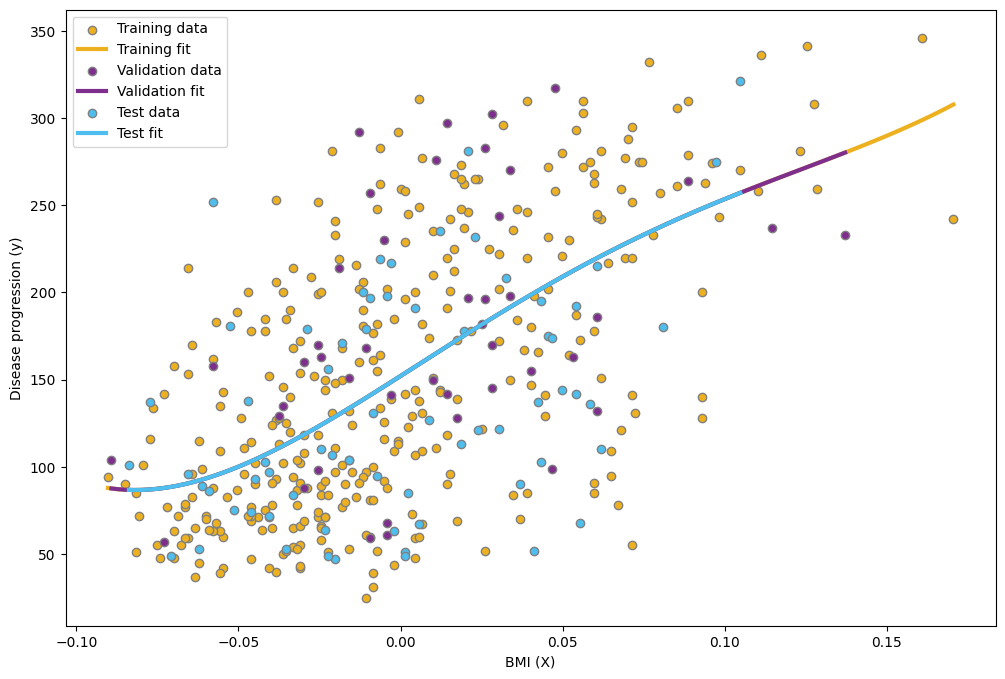

In [58]:
data_list = [(X_train_diabetes.values.reshape(-1,1), y_train_diabetes),
             (X_val_diabetes.values.reshape(-1,1), y_val_diabetes),
             (X_test_diabetes.values.reshape(-1,1), y_test_diabetes)]
types_list = ["Training", "Validation", "Test"]
color_list = ["#EDB120", "#7E2F8E", "#4DBEEE"]

plot_models(data_list, models[4], color_list, types_list)

*Equation of the best model.*

In [59]:
def print_equation(model):
    equation = f"y = {model[1].intercept_:.2f}" ## start with intercept

    ## then print the coefficients
    for ind, coeff in enumerate(model[1].coef_):
        degree = ind + 1
        if coeff < 0:
            equation += f" - {abs(coeff):.2f}x^{degree}"
            continue
        else:
            equation += f" + {coeff:.2f}x^{degree}"
            
    print(f'Equation: {equation}')

print_equation(models[4])

Equation: y = 152.09 + 0.00x^1 + 1184.00x^2 + 632.77x^3 - 37896.70x^4 + 145723.39x^5


*Calculate the expected diabetes progression for a chosen BMI value.*

In [60]:
# Side note: The only way I found to get a normal result using the model.predict() 
# was to find the original dataset and calculate the standardize BMI value of my choice by hand

## Import original dataset
url = "https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt"
original_df = pd.read_csv(url, sep="\t")  # Tab-separated file

## Get mean and standard deviation
original_mean, original_std = original_df["BMI"].mean(), original_df["BMI"].std()
n_samples = len(original_df)


In [61]:
## Calculate BMI value
height = 1.57
weight = 54
my_BMI = weight/height**2

## Standardize the BMI value by mean centering and scaling by the 
# standard deviation times the square root of number of samples
my_BMI_scaled = (my_BMI - original_mean) / (original_std * np.sqrt(n_samples))
X_BMI = np.array([[my_BMI_scaled]]) ## reshape X_BMI for sklearn calculation 

In [62]:
# Redo the fit of the Polynomial regression model for chosen degree (4)
poly_features = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_features.fit_transform(X_train_diabetes.values.reshape(-1,1))

model = LinearRegression()
model.fit(X_poly, y_train_diabetes)

# Predict a the BMI value
predicted_BMI = model.predict(poly_features.transform(X_BMI))
print(f'Expected diabetes progression for a bmi of {my_BMI:.2f} is {predicted_BMI[0]:.2f}.')

Expected diabetes progression for a bmi of 21.91 is 101.60.


*How many trainable parameters are we fitting for each of the models?*

In [63]:
for degree, model in models.items():
    poly_features = model.named_steps['polynomial']
    feature_names = poly_features.get_feature_names_out()
    # Print the feature names
    print(f"Degree {degree} feature names: {feature_names}")

Degree 0 feature names: ['1']
Degree 1 feature names: ['1' 'x0']
Degree 2 feature names: ['1' 'x0' 'x0^2']
Degree 3 feature names: ['1' 'x0' 'x0^2' 'x0^3']
Degree 4 feature names: ['1' 'x0' 'x0^2' 'x0^3' 'x0^4']
Degree 5 feature names: ['1' 'x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5']


The number of trainable parameters for each model is based on the polynomial degree. This mean that a model with degree 0 has only one trainable parameter (the intercept), a model with degree 1 has two trainable parameters (the intercept and 1 coefficient for x0) and so on, increasing the number of coefficients based on the degree (model with degree 5 has 5 coefficients and 6 trainable parameters).

### Conclusion
The chosen model (of degree 4), demonstrated the best performance out of all the trained models. However, despite the good results, the model's predictive capacity is still limited, as indicated by the low R-Squared scores. The big difference between the training and validation results indicate that the model might be overfitting, meaning that the model learns patterns in the training data but fails to predict on the unseen data from the validation set.

The scatter plot from earlier which ilustrated the relationship between the BMI and disease progression, showed that the model's best fit lines overlap each other. This suggest that the chosen model is consistent across all sets, contradicting the initial assumption of overfitting. This consistency also supports the idea that BMI might be the most meaningful feature to predict diabetes progression, as we identified in the correlation matrix. 

**Limitations**
- Overfitting: Polynomial regression is prone to overfitting when the degree is high, as indicated by the big gap between the training and validation metrics. 
- Model fit: Polynomial regression might not be a good fit for the chosen dataset, as observed in the performance limitations.
- Generalization: Polynomial models are known for their limited capacity to generalize a complex relationship between features and target. More flexible models like decision trees or KNNs, might be a better alternative for this problem.

## Part 3
Repeat the steps in part 2 for the following models:
1. Two polynomial models (degrees >1, of your choice)
2. Two decision trees (e.g. consider changing the `max_depth` hyperparameter)
3. Two kNNs


### Fitting models


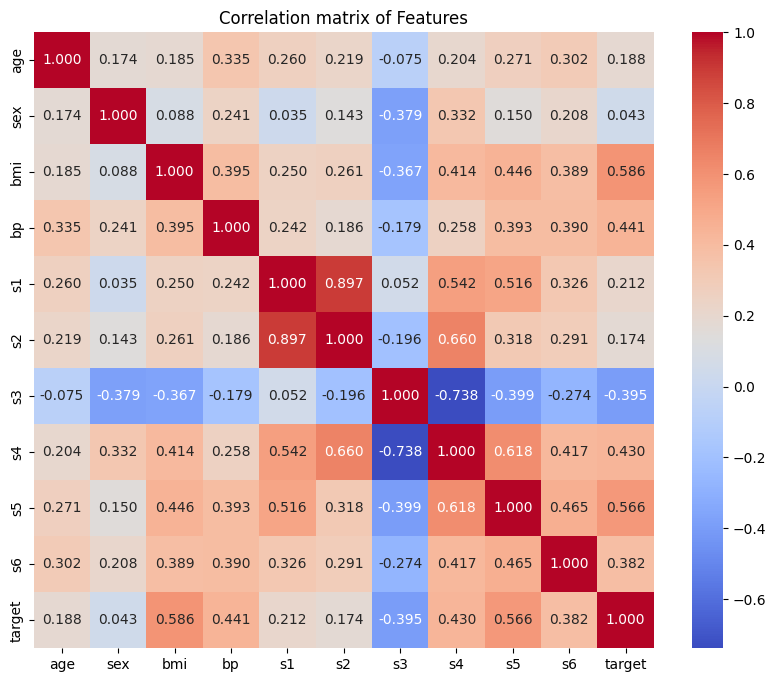

In [64]:
## replotting the correlation matrix to choose new features
plt.figure(figsize=(10,8))
sns.heatmap(corr_X, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation matrix of Features')
plt.show()

Based on the correlation matrix, the highest correlation with the target variable is almost 0.6. Therefore, I will select the features that show a correlation greater than 0.3 with the target value.

However, even if it shows a strong negative correlation with the target value (-0.395), I decided to ignore s3 because of its high multicollinearity with s4 (-0.738). This indicates that the two features are inversely related, making them reduntant. Since s4 shows a higher correlation with the target variable, I will keep s4 and drop s3 from analysis to avoid redudancy. 

The final dataset used for the Multivariate Polynomial models includes the following features:
- bmi, body mass index
- bp, blood pressure
- s4, total cholesterol / HDL
- s5, possibly log of serum triglycerides level
- s6, blood sugar level

In [65]:
chosen_X = diabetes_X[['bmi', 'bp', 's4', 's5', 's6']]

### 2. Multivariate Polynomial model

In [66]:
## Step 5: split dataset into train, validation and test sets
X_train_mult, X_test_mult, y_train_mult, y_test_mult = train_test_split(
        chosen_X, diabetes_y, test_size=1-train_ratio, random_state=0)
X_val_mult, X_test_mult, y_val_mult, y_test_mult = train_test_split(
        X_test_mult, y_test_mult, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)

In [67]:
## Step 6: fit the two polynomial models with chosen degrees

## Model 1 has a degree of 2
model1 = Pipeline([('polynomial', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])
model1.fit(X_train_mult, y_train_mult)

## Model 2 has a degree of 4
model2 = Pipeline([('polynomial', PolynomialFeatures(degree=4)),
                  ('linear', LinearRegression())])
model2.fit(X_train_mult, y_train_mult)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=4)),
                ('linear', LinearRegression())])

In [68]:
## Step 7: compare the models using the training and validation data
mult_models = []
def comparison_table(model, degree, results, firstcolumn="Model degree"):
        y_pred_train = model.predict(X_train_mult)
        y_pred_val = model.predict(X_val_mult)

        R2_train, MAE_train, MAPE_train = calculate_results(y_train_mult, y_pred_train)
        R2_val, MAE_val, MAPE_val = calculate_results(y_val_mult, y_pred_val)
        results.append((degree, R2_train, R2_val, MAE_train, MAE_val, MAPE_train, MAPE_val))

        df = pd.DataFrame(results, columns=[
                firstcolumn, 'Train R-Squared', 'Validation R-Squared', 'Train MAE', 'Validation MAE', 'Train MAPE', 'Validation MAPE'])
        return df

comparison_table(model1, 2, mult_models)
comparison_table(model2, 4, mult_models)


,Model degree,Train R-Squared,Validation R-Squared,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,2,0.5465,0.1244,44.4353,53.0256,0.3968,0.3285
1,4,0.7171,-1.4576,33.1133,65.5114,0.3092,0.4314


***Step 8: identify the best model based on the table above***

The multivariate model of degree 2 performs better than the model of degree 4. Interesting enough, the degree 4 model is performing poorly in a multivariate polynomial model compared to the univariate one we analyzed earlier. 

While the model of degree 4 has a higher Train R-Squared compared to the degree 2 model (0.5465 < 0.7171), the validation R-Squared shows a huge drop in the performance of the model, meaning that the model is not good at generalizing on unseen data. Additionally, the degree 4 model shows higher validation MAE and MAPE than the training results, suggesting potential overfitting.

After this evalution, I will choose the degree 2 model as thebest performing model due to the balanced performance across all errors and a smaller gap between R-Squared scores.

**Best model: Model with degree 2**
- Less difference between training and validation R-Squared
- The MAE and MAPE results are stable across training and validation sets
- It's overall the better choice compared to degree 4 model

In [69]:
## Step 9: run the chosen model on the test set and provide results
y_pred_test1 = model1.predict(X_test_mult)
R2_test1, MAE_test1, MAPE_test1 = calculate_results(y_test_mult, y_pred_test1)

print(f"Model degree 2 test metrics:\n R-Squared: {R2_test1}\n MAE: {MAE_test1}\n MAPE: {MAPE_test1}")


Model degree 2 test metrics:
 R-Squared: 0.31094459666981167
 MAE: 43.240615277562
 MAPE: 0.4349740794000781


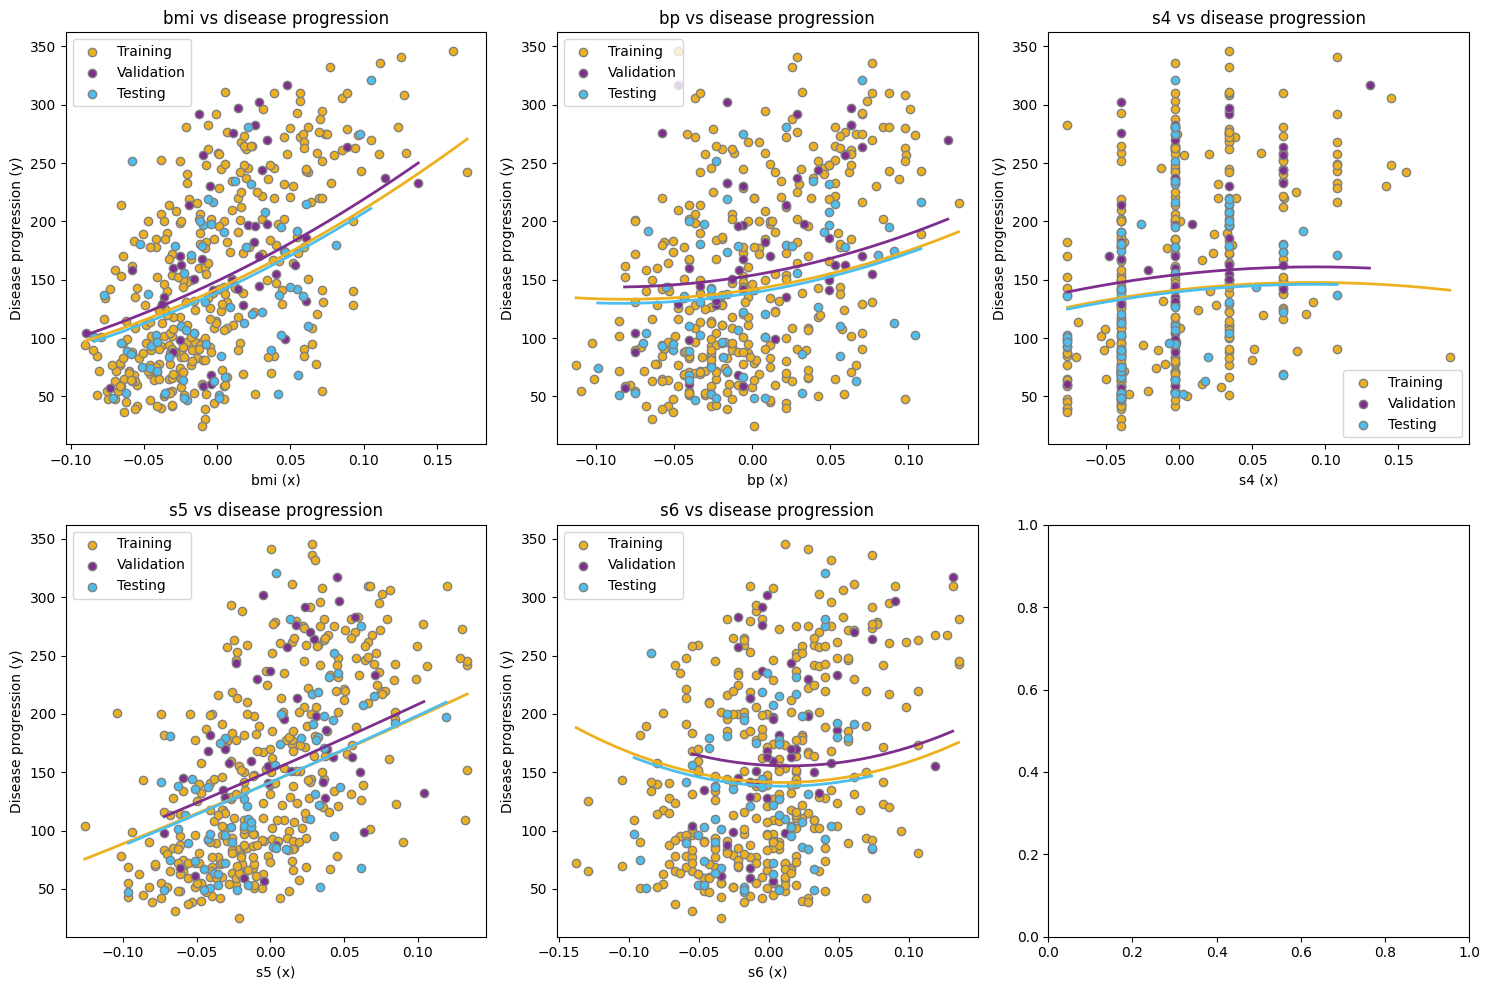

In [70]:
## Step 10: plot a graph of the train, validation and test data points, 
# and the fit of the chosen model over each of them
mult_data = [(X_train_mult, y_train_mult),
             (X_val_mult, y_val_mult),
             (X_test_mult, y_test_mult)]
features = ['bmi', 'bp', 's4', 's5', 's6']

## helper function to plot multiple features that will be used in later models
def plot_multivariate_model(model):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
    axes = axes.flatten()

    ## scatter data points and best fit line for train, validation and test sets
    ## then do it all again for all features included in multivariate analysis
    for i, feature in enumerate(features):
        axes[i].scatter(X_train_mult[feature], y_train_mult, 
                        edgecolor="grey", c=color_list[0], label="Training")
        axes[i].scatter(X_val_mult[feature], y_val_mult, 
                        edgecolor="grey", c=color_list[1], label="Validation")
        axes[i].scatter(X_test_mult[feature], y_test_mult, 
                        edgecolor="grey", c=color_list[2], label="Testing")

        for data, color in zip(mult_data, color_list):
            X, y = data

            X_continuous = np.linspace(min(X[feature]), max(X[feature]), 331)
            ## create a new DataFrame with the same structure as X_train, where all values in the 
            ## features that are not the current will be replaced with the mean of the column 
            X_fixed = pd.DataFrame(np.tile(X[features].mean().values, (331, 1)), columns=features)
            X_fixed[feature] = X_continuous
            
            ## plot the best-fit curve
            axes[i].plot(X_continuous, model.predict(X_fixed), color=color, linewidth=2)

        axes[i].set_xlabel(feature + " (x)")
        axes[i].set_ylabel("Disease progression (y)")
        axes[i].set_title(f"{feature} vs disease progression")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_multivariate_model(model1) 

In [71]:
## Step 11: write down the equation of the best model
poly_features1 = model1.named_steps['polynomial']
features1 = poly_features1.get_feature_names_out()

equation = f"y = {model1[1].intercept_:.2f}"
for coeff, feature in zip(model1[1].coef_, features1):
    if coeff == 0:
        continue
    if coeff < 0:
        equation += f" - {abs(coeff):.2f}*{feature}"
    else:
        equation += f" + {coeff:.2f}*{feature}"
        
print(f'Equation: {equation}')

Equation: y = 142.30 + 587.02*bmi + 209.37*bp + 138.15*s4 + 546.61*s5 - 44.01*s6 + 983.87*bmi^2 + 1799.93*bmi bp + 1474.74*bmi s4 + 2296.50*bmi s5 - 2336.55*bmi s6 + 1273.02*bp^2 - 1602.02*bp s4 - 696.20*bp s5 + 1241.52*bp s6 - 754.27*s4^2 - 959.13*s4 s5 + 453.75*s4 s6 + 164.51*s5^2 - 559.78*s5 s6 + 2163.97*s6^2


In [93]:
## Step 12: calculate the expected diabetes progression for a BMI value of your choice

## when predicting BMI the other features should be set to 0 to not affect the prediction
X_BMI_multi = pd.DataFrame([[my_BMI_scaled, 0, 0, 0, 0]], columns=['bmi', 'bp', 's4', 's5', 's6']) 
predicted_BMI_multi = model1.predict(X_BMI_multi)
print(f'Expected diabetes progression for a bmi of {my_BMI:.2f} is {predicted_BMI_multi[0]:.2f}.')


Expected diabetes progression for a bmi of 21.91 is 116.34.


In [73]:
## Step 13: show how many training parameters are fit for each of the models
print(f"Model of degree 2 uses {features1.size} training parameters.")
print(f"Feature names: \n{features1}")

poly_features2 = model2.named_steps['polynomial']
features2 = poly_features2.get_feature_names_out()

print(f"Model of degree 4 uses {features2.size} training parameters.")
print(f"Feature names: \n{features2}")


Model of degree 2 uses 21 training parameters.
Feature names: 
['1' 'bmi' 'bp' 's4' 's5' 's6' 'bmi^2' 'bmi bp' 'bmi s4' 'bmi s5' 'bmi s6'
 'bp^2' 'bp s4' 'bp s5' 'bp s6' 's4^2' 's4 s5' 's4 s6' 's5^2' 's5 s6'
 's6^2']
Model of degree 4 uses 126 training parameters.
Feature names: 
['1' 'bmi' 'bp' 's4' 's5' 's6' 'bmi^2' 'bmi bp' 'bmi s4' 'bmi s5' 'bmi s6'
 'bp^2' 'bp s4' 'bp s5' 'bp s6' 's4^2' 's4 s5' 's4 s6' 's5^2' 's5 s6'
 's6^2' 'bmi^3' 'bmi^2 bp' 'bmi^2 s4' 'bmi^2 s5' 'bmi^2 s6' 'bmi bp^2'
 'bmi bp s4' 'bmi bp s5' 'bmi bp s6' 'bmi s4^2' 'bmi s4 s5' 'bmi s4 s6'
 'bmi s5^2' 'bmi s5 s6' 'bmi s6^2' 'bp^3' 'bp^2 s4' 'bp^2 s5' 'bp^2 s6'
 'bp s4^2' 'bp s4 s5' 'bp s4 s6' 'bp s5^2' 'bp s5 s6' 'bp s6^2' 's4^3'
 's4^2 s5' 's4^2 s6' 's4 s5^2' 's4 s5 s6' 's4 s6^2' 's5^3' 's5^2 s6'
 's5 s6^2' 's6^3' 'bmi^4' 'bmi^3 bp' 'bmi^3 s4' 'bmi^3 s5' 'bmi^3 s6'
 'bmi^2 bp^2' 'bmi^2 bp s4' 'bmi^2 bp s5' 'bmi^2 bp s6' 'bmi^2 s4^2'
 'bmi^2 s4 s5' 'bmi^2 s4 s6' 'bmi^2 s5^2' 'bmi^2 s5 s6' 'bmi^2 s6^2'
 'bmi bp^3'

### Conclusions

The multivariate polynomial model (of degree 2) demostrated a better performance compared to the degree 4 model, as shown by the stable metrics across the training, validation and test sets. The low training R-Squared (0.5465) indicates that the model is relatively good for predicting disease progression. However, as concluded earlier in the univariate model, the gap between validation and the other sets suggests that the model fails to generalize on unseen data. The similar MAE error for the training and test sets, however, indicate that overfitting is unlikely.

From the scatter plots, we can observe that the best-fit curve for the validation set deviates from the training and test curves, suggesting again the model's problem with generalization. Aditionally, 3 out of 5 plots predict a horizontal curve, which might be due to the weak correlation between these features and the target variable (bp, s4 and s6 each have correlations around 0.4). Meanwhile, the s5 feature shows a linear relationship rather than the expected non-linear curve, indicating that the model may have failed to capture the pattern.

**Limitations**
- Complexity: The multivariate model performs better on a lower polynomial degree, reducing overfitting. However, increasing the degree leads to a drop in performance, as shown by the validation metrics.
- Validation: The low validation R-Squared (0.1244) indicates poor generalization on new data, meaning that the model might not be reliable for predicting disease progression. Again, a more flexible approach for a multivariate analysis like decision trees or KNNs, might be better suited to capture the data's complexity.
- Feature relationships: The model fails to capture interactions between features, as seen in the horizontal curves and the linear relationship with the s5 feature. This suggests that polynomial regression might not be fitted to represent the patterns in the data.


### 3. Decision Trees

In [74]:
## Step 6: fit the two polynomial models with chosen degrees
tree_model1 = tree.DecisionTreeRegressor(max_depth=2)
tree_model1.fit(X_train_mult, y_train_mult)

tree_model2 = tree.DecisionTreeRegressor(max_depth=3)
tree_model2.fit(X_train_mult, y_train_mult)

DecisionTreeRegressor(max_depth=3)

In [75]:
## Step 7: compare the models using the training and validation data
tree_models = []

comparison_table(tree_model1, 2, tree_models, "Decision tree depth")
comparison_table(tree_model2, 3, tree_models, "Decision tree depth")

,Decision tree depth,Train R-Squared,Validation R-Squared,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,2,0.4964,0.0147,44.8299,55.0870,0.4099,0.3480
1,3,0.5712,-0.0113,41.5115,56.2157,0.3795,0.3459


***Step 8: identify the best model based on the table above***

The decision tree of depth 3 performs the best on the training data, although it fails to generalize on the validation data even worse than the decision tree of depth 2. Despite the potential risk of overfitting, depth 3 might still be the better choce overall, mostly due to the unsignificant difference between the validation R-Squared values of the two models.

**Best model: Decision tree of max depth of 3**
- Higher Train R-Squared (0.5712)
- The negative Validation R-Squared (-0.0113) suggests overfitting. However, the difference in performance might be insignificant enough to be considered the better choice
- Lower Train MAPE (0.3795), indicating better accuracy on the training set

In [76]:
## Step 9: run the chosen model on the test set and provide results
y_pred_test_tree2 = tree_model2.predict(X_test_mult)
R2_test_tree2, MAE_test_tree2, MAPE_test_tree2 = calculate_results(y_test_mult, y_pred_test_tree2)

print(f"Decision tree model depth 3 test metrics:\n R-Squared: {R2_test_tree2}\n MAE: {MAE_test_tree2}\n MAPE: {MAPE_test_tree2}")

Decision tree model depth 3 test metrics:
 R-Squared: 0.08450053354491938
 MAE: 50.15090890444581
 MAPE: 0.4823076669177553


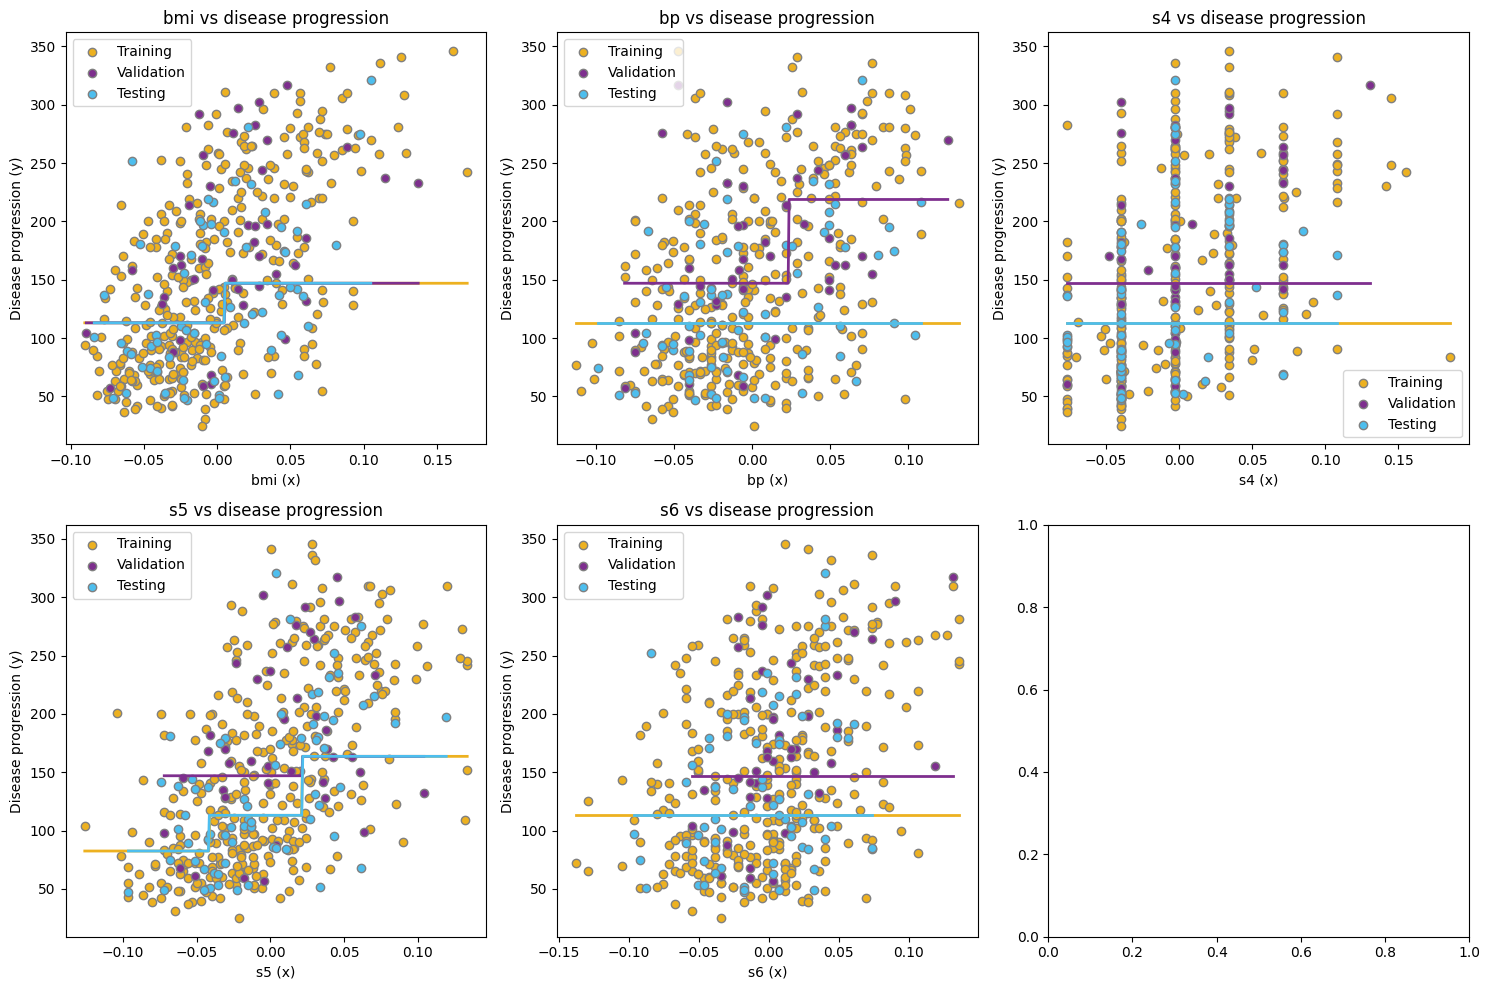

In [77]:
## Step 10: plot a graph of the train, validation and test data points, and the fit of the chosen model over each of them
plot_multivariate_model(tree_model2)

|--- s5 <= 0.02
|   |--- bmi <= 0.01
|   |   |--- s5 <= -0.04
|   |   |   |--- value: [82.43]
|   |   |--- s5 >  -0.04
|   |   |   |--- value: [113.02]
|   |--- bmi >  0.01
|   |   |--- bp <= 0.02
|   |   |   |--- value: [146.95]
|   |   |--- bp >  0.02
|   |   |   |--- value: [218.76]
|--- s5 >  0.02
|   |--- bmi <= 0.01
|   |   |--- bp <= 0.06
|   |   |   |--- value: [163.57]
|   |   |--- bp >  0.06
|   |   |   |--- value: [261.25]
|   |--- bmi >  0.01
|   |   |--- bmi <= 0.06
|   |   |   |--- value: [230.89]
|   |   |--- bmi >  0.06
|   |   |   |--- value: [264.12]



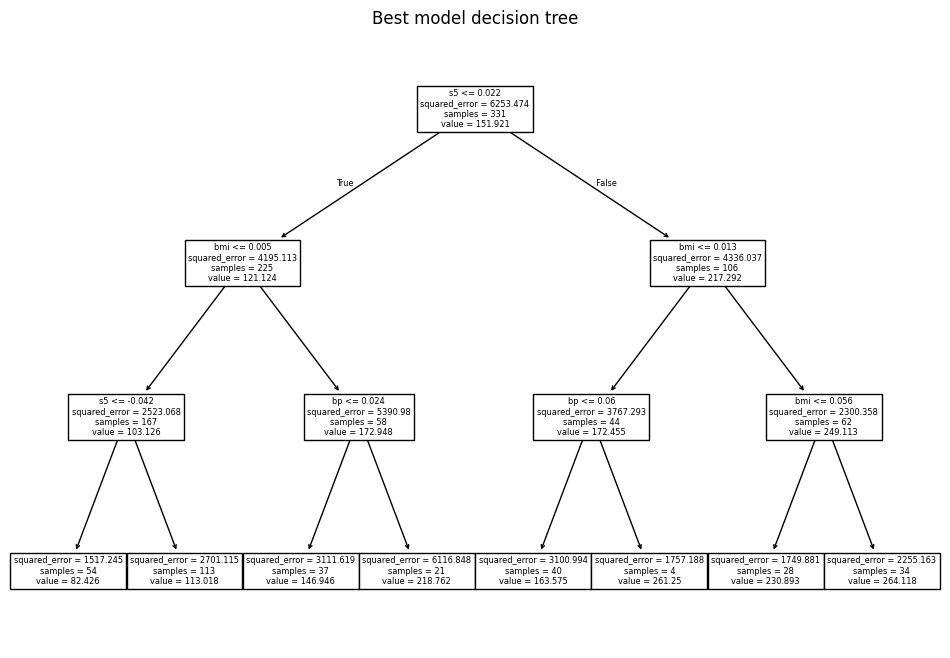

In [78]:
## Step 11: write down the equation of the best model

## textual representation of the decicisions "equation" taken by the tree model
tree_rules = tree.export_text(tree_model2, feature_names=list(X_train_mult.columns))
print(tree_rules)

## plotted representation of the "equation"
plt.figure(figsize=(12,8))
tree.plot_tree(tree_model2, feature_names=X_train_mult.columns)
plt.title('Best model decision tree')
plt.show()

In [94]:
## Step 12: calculate the expected diabetes progression for a BMI value of your choice
predicted_BMI_tree = tree_model2.predict(X_BMI_multi)
print(f'Expected diabetes progression for a bmi of {my_BMI:.2f} is {predicted_BMI_tree[0]:.2f}.')


Expected diabetes progression for a bmi of 21.91 is 113.02.


***Step 13: show how many training parameters are fit for each of the models***

The number of "training parameters" in decision trees is seen in:
- number of nodes and leaf nodes
- importance given to features
- number of splits

In [80]:
nodes = tree_model2.tree_.node_count
leaf_nodes = sum(tree_model2.tree_.children_left == tree_model2.tree_.children_right)

feature_importances = tree_model2.feature_importances_
importances = pd.Series(feature_importances, index=X_train_mult.columns)

splits = nodes - leaf_nodes

print(f"Nodes count: {nodes}")
print(f"Leaf nodes count: {leaf_nodes}")
print(f"Feature importances:\n{importances}")
print(f"Split count: {splits}")


Nodes count: 15
Leaf nodes count: 8
Feature importances:
bmi   0.3197
bp    0.0878
s4    0.0000
s5    0.5925
s6    0.0000
dtype: float64
Split count: 7


### Conclusion

The chosen decision tree model with a max depth of 3 shows better performance and a stronger fit to the training data, with a Train R-Squared of 0.5712. However, we can observe limitations in the model's ability to generalize, as seen by the negative validation R-Squared of -0.0113. The model appears to be overfitting, meaning it learns the training data instead of capturing patterns used for making accurate predictions on unseen data. This is further supported by the increased error on the validation set. 

Despite these limitations, the depth 3 model is still considered to be the better choice compared to the depth 2 model, mainly due to the higher R-Squared and the lower MAPE. Moreover, the model fails to capture all the relationships between the 5 features, giving a higher importance to only a few, which doesn't seem enough to observe the full complexity of the data. 

This is further highlighted in the scatter plots. While bmi, bp and s5 contribute to the tree's decisions, s4 and s6 are disregarded, as indicated by their horizontal fit lines. This suggests that the model doesn't use these features, leading to a potential loss of valuable information. 

By analyzing the active features, we can see that the bmi fit lines for the training, validation and testing sets overlap, confirming that this feature is consistently important across all sets. However, the single step in the staircase pattern suggests a simplistic relationship with the target variable. Aditionally, the bp feature only displays a single step in the validation fit, while the training and testing sets show no meaningful response to changes in blood pressure. The most important feature, s5 (0.5925), still shows inconsistency: training and testing fits show two decision steps, while the validation set shows one. This indicates that the model identifies a relationship in the training data but fails to generalize it across the validation set. 

**Limitations**
- Overfitting: The decision tree performs better on the training data than on the validation, suggesting that it captures noise rather than figuring out patterns. 
- Feature importance: The model relies only on bmi, bp and s5, while s4 and s6 features are considered irrelevant to the analysis. This limits the ability of the model to capture the full complexity of the data.
- Fit lines: The model is shows inconsistent decision patterns between training, validation and testing, which reduces confidence in predictions on new data.

### 4. kNNs

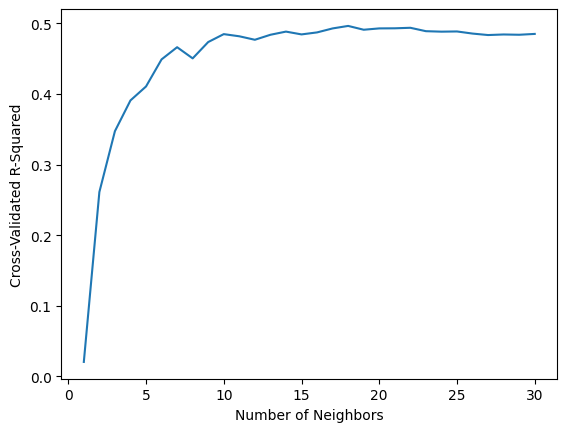

In [81]:
## algorithm to choose the k values best fitted for our analysis
k_range = range(1, 31)
mean_scores = []

for k in k_range:
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    
    ## check cross-validation score for each k value in the range based on r-squared
    score = cross_val_score(knn, X_train_mult, y_train_mult, scoring='r2')
    mean_scores.append(score.mean())

plt.plot(k_range, mean_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated R-Squared')
plt.show()

In [82]:
## Step 6: fit the two polynomial models with chosen degrees
knn_model1 = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_model1.fit(X_train_mult, y_train_mult)

knn_model2 = neighbors.KNeighborsRegressor(n_neighbors=10)
knn_model2.fit(X_train_mult, y_train_mult)

KNeighborsRegressor(n_neighbors=10)

In [83]:
## Step 7: compare the models using the training and validation data
knn_models = []

comparison_table(knn_model1, 5, knn_models, "K-Nearest neighbors")
comparison_table(knn_model2, 10, knn_models, "K-Nearest neighbors")

,K-Nearest neighbors,Train R-Squared,Validation R-Squared,Train MAE,Validation MAE,Train MAPE,Validation MAPE
0,5,0.6004,-0.1678,39.7758,61.7727,0.3501,0.3543
1,10,0.5600,-0.0580,42.1139,56.5750,0.3651,0.3261


***Step 8: identify the best model based on the table above***

The KNN model with k=10 looks to be a better choice compared to k=5 despite its lower training performance (0.5600 < 0.6004). Even if the model that considers 5 neighbors seems to have a better Train R-Squared and lower Train MAE, it fails to generalize on the validation set, as indicated by the lower negative Validation R-Squared (-0.1678) and the higher Validation MAE (61.7727).

The k=10 model, on the other hand, demonstrates slightly weaker performance on the training data but achieves better validation results, with a less negative Validation R-Squared (-0.0580) and a lower Validation MAE (56.5750). Additionally, its Validation MAPE (0.3261) is lower compared to the k=5 model (0.3543), indicating better predictive accuracy for unseen data.

**Best model: KNN with 10 neighbors**
- Better Validation R-Squared (-0.0580)
- Lower Validation MAE (56.5750)
- Lower Validation MAPE (0.3261)

In [84]:
## Step 9: run the chosen model on the test set and provide results
y_pred_test_knn2 = knn_model2.predict(X_test_mult)
R2_test_knn2, MAE_test_knn2, MAPE_test_knn2 = calculate_results(y_test_mult, y_pred_test_knn2)

print(f"KNN model with 10 neighbors test metrics:\n R-Squared: {R2_test_knn2}\n MAE: {MAE_test_knn2}\n MAPE: {MAPE_test_knn2}")

KNN model with 10 neighbors test metrics:
 R-Squared: 0.40997886799059946
 MAE: 39.67611940298507
 MAPE: 0.39451921948545876


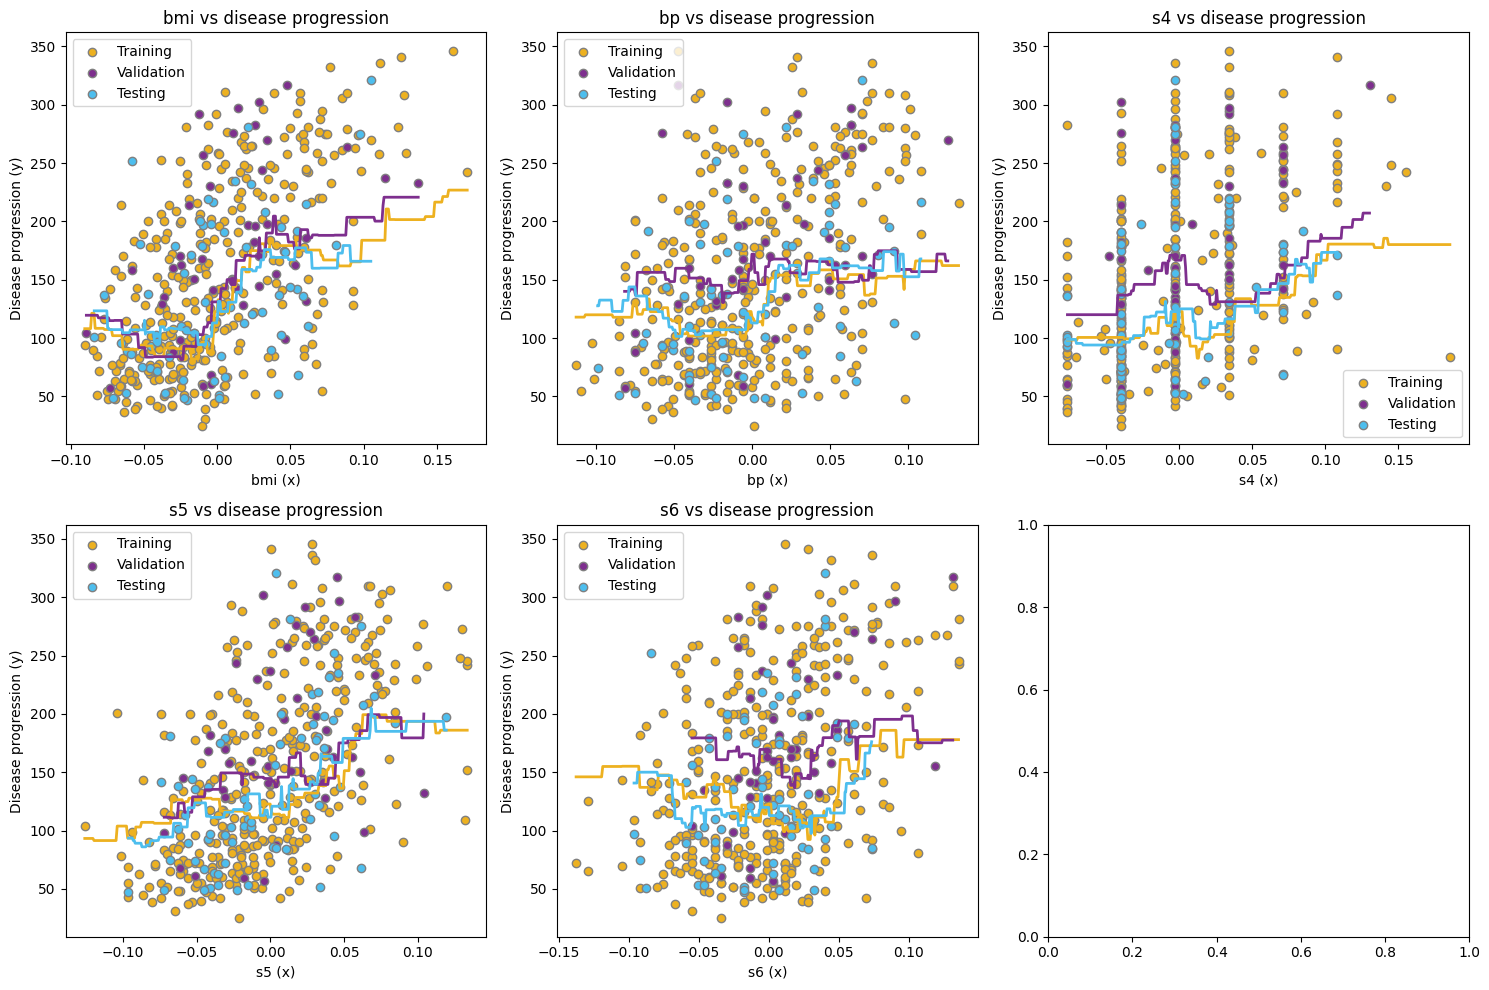

In [85]:
## Step 10: plot a graph of the train, validation and test data points, and the fit of the chosen model over each of them
plot_multivariate_model(knn_model2)

In [86]:
## Step 11: write down the equation of the best model
# I'll use the Euclidean distance equation for all features
equation = "Distance(X_pred, X_actual) = sqrt("

for feature in features:
    equation += f"({feature}_pred - {feature}_actual)^2 + "

print(f"{equation[:-3] + ')'}")


Distance(X_pred, X_actual) = sqrt((bmi_pred - bmi_actual)^2 + (bp_pred - bp_actual)^2 + (s4_pred - s4_actual)^2 + (s5_pred - s5_actual)^2 + (s6_pred - s6_actual)^2)


In [87]:
## Step 12: calculate the expected diabetes progression for a BMI value of your choice
predicted_BMI_knn = knn_model2.predict(X_BMI_multi)
print(f'Expected diabetes progression for a bmi of {my_BMI:.2f} is {predicted_BMI_knn[0]:.2f}.')

Expected diabetes progression for a bmi of 21.91 is 93.20.


c:\Users\Madalina\OneDrive - Conestoga College\Conestoga\January-April\Foundations of Machine Learning Frameworks\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


***Step 13: show how many training parameters are fit for each of the models***

The number of "training parameters" in kNN models is seen in:
- number of training samples
- number of features

In [88]:
train_samples = X_train_mult.shape[0]
features_count = X_train_mult.columns.shape[0]
total = train_samples * features_count + train_samples

print(f"Training parameters (training samples * features + target samples): {total}")

Training parameters (training samples * features + target samples): 1986


### Conclusion

The chosen KNN model with 10 neighbors demonstrated slightly better performance, due to the higher validation R-Squared value of -0.0580. The chosen model also achieves a test R-Squared of 0.4099, indicating that while the model struggles to generalize well on the validation set, it shows a good performance on the unseen test data. The lower training and validation errors further support this, as indicated by the lower MAE and MAPE values.

When analyzing the scatter plots, we can observe distinct patterns across the features. The bmi and s5 show a clear increasing trend, with the fit lines almost overlapping across the training, validation and testing sets. This suggests a consistent relationship with the target variable. In contrast, the bp feature shows no trend with disease progression, indicating limited predictive relevance. Meanwhile, the S4 and S6 features show validation fit lines that diverge from the training and testing ones, suggesting either potential noise (as observed a lot in the scattered data points) or underfitting.

This behaviour aligns with characteristics of the KNN algorithm. When there is a single neighbor, predictions tend to be very sensitive to individual data points, resulting in unsteady predictions that closely follow the training data. By increasing the neighbor count to 10, the model produces smoother predictions that generalize new data better, despite the slight drop in training performance.

**Model Limitations:**
- Validation: The negative validation R-Squared indicates difficulties in predicting on new data, despite the good performance on the test set.
- Relevance: The bp, s4 and s6 features show limited relationships with the dependent variable, maybe leading to the omission of important information.
- Sensitivity: KNN models are sensitive to noisy data when fewer neighbors are used.